In [3]:
# My Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# My Technical Report: Multiple Linear Regression Analysis

#### Introduction

The goal of this analysis is to understand how different factors affect sleep and mood in teenagers, based on the study "A Cognitive Vulnerability Model of Sleep and Mood in Adolescents under Naturalistically Restricted and Extended Sleep Opportunities." I will use synthetic data similar to what's described in the study to do a multiple linear regression analysis. The main factors I'll look at are the time it takes to fall asleep (SOLacti), how good the sleep feels (SSQ), negative thinking patterns (DAS), and mood (MOOD).

#### Methodology

I will start by creating a synthetic dataset based on the study's details. I'll look at how the main factors are distributed, check how they relate to each other, fit multiple regression models, and check the model's accuracy. I'll also visualize the relationships. This report shows the process and findings using Python.

#### Synthetic Data Generation

The dataset was generated using the following parameters:

* SOLacti: Number of minutes it takes to fall asleep, normally distributed.
* DBAS: Dysfunctional beliefs about sleep, normally distributed.
* DAS: Dysfunctional attitudes, normally distributed.
* Female: Binary variable indicating gender.
* Stress: Stress levels, normally distributed.
* SSQ: Subjective sleep quality, calculated based on a formula involving the above variables.
* MOOD: Mood, calculated based on a formula involving the above variables.

In [4]:
np.random.seed(0)

# Generate synthetic data
SOLacti = np.random.normal(4.4, 1.3, 150)**2
DBAS = np.random.normal(72, 26, 150)
DAS = np.random.normal(125, 32, 150)
Female = np.random.binomial(1, 0.53, 150)
Stress = np.random.normal(32, 11, 150)

# Define SSQ and MOOD as per the given formula
SSQ = np.random.normal((0.36*3/12.5)*SOLacti + (0.16*3/26)*DBAS + (0.18*3/0.5)*Female + (0.20*3/11)*Stress, 2.6, 150)
MOOD = np.random.normal((-0.07/12.5)*SOLacti + (0.29/3)*SSQ + (0.14/26)*DBAS + (0.21/32)*DAS + (0.12/32)*SSQ*(DAS-50) + (0.44/0.5)*Female + (0.28/11)*Stress, 2, 150)

# Create a DataFrame
adosleep = pd.DataFrame({'SOLacti': SOLacti, 'DBAS': DBAS, 'DAS': DAS, 'Female': Female, 'Stress': Stress, 'SSQ': SSQ, 'MOOD': MOOD})
adosleep['Female'] = adosleep['Female'].map({0: 'Males', 1: 'Females'})

# Display the synthetic dataset
adosleep.head()

,SOLacti,DBAS,DAS,Female,Stress,SSQ,MOOD
0,44.799837,70.225718,83.191141,Males,54.123823,6.286594,5.749443
1,24.208411,116.546911,178.060182,Females,31.509450,8.809874,8.769930
2,32.175661,52.636375,121.218751,Females,34.145767,4.883773,4.466439
3,53.482326,50.512598,103.234297,Females,12.402809,6.554898,3.986767
4,46.619200,69.440234,146.324259,Females,23.980509,11.150135,8.123746


#### Distribution Inspection and Outlier Identification
I inspected the distribution of core variables (MOOD, SSQ, SOLacti, DAS) using histograms and boxplots.

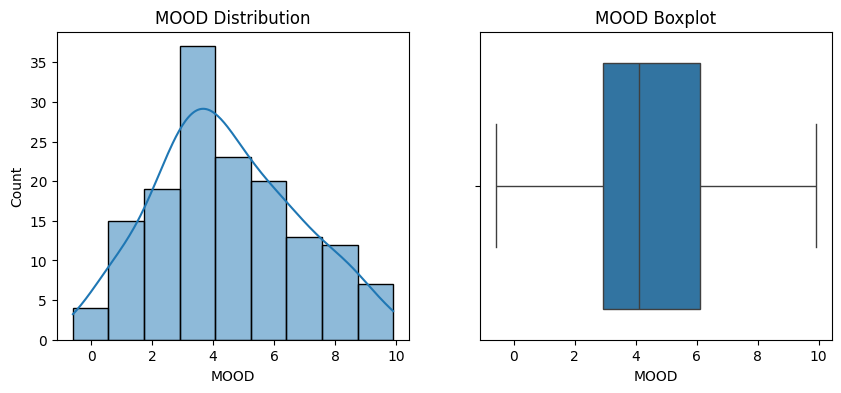

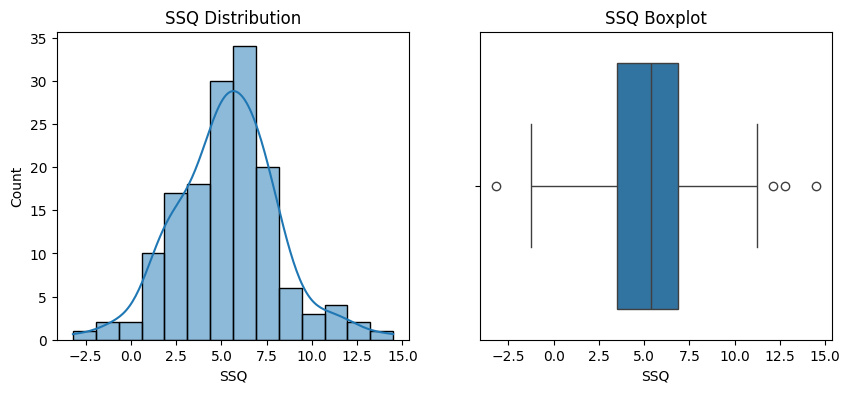

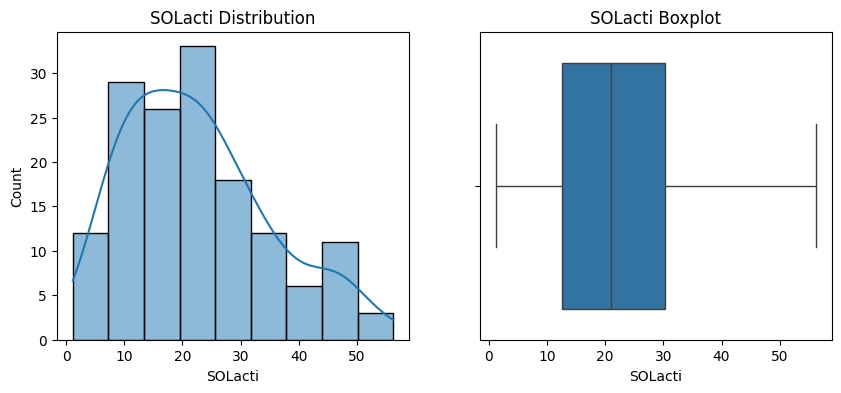

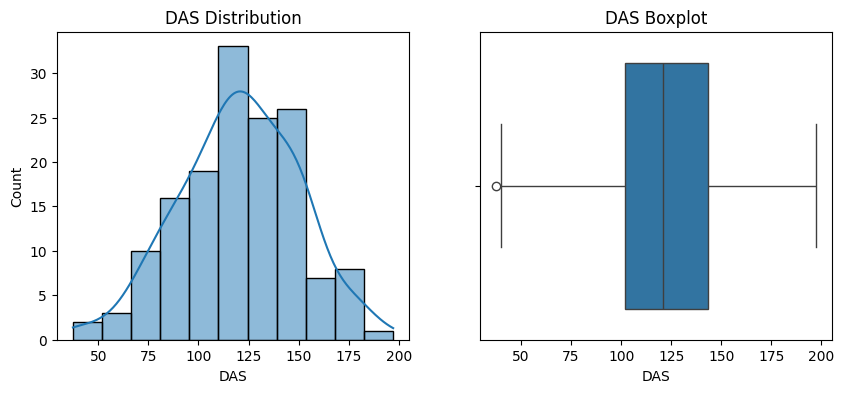

In [5]:
# Plot the distribution of each variable
variables = ['MOOD', 'SSQ', 'SOLacti', 'DAS']

for var in variables:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(adosleep[var], kde=True)
    plt.title(f'{var} Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=adosleep[var])
    plt.title(f'{var} Boxplot')
    
    plt.show()

#### Bivariate Correlations
I computed and plotted the correlations between study variables.

In [6]:
# Compute the correlation matrix
corr_matrix = adosleep.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

ValueError: could not convert string to float: 'Males'

#### Multiple Regression Models
Three regression models were fitted and compared:

* Model 1: Covariates only (Female, Stress)
* Model 2: Covariates + main constructs (SSQ, DBAS)
* Model 3: Model 2 + interaction between SSQ and DAS

In [ ]:
# Prepare the predictors
X1 = adosleep[['Female', 'Stress']]
X1 = pd.get_dummies(X1, drop_first=True)
X1 = sm.add_constant(X1)

X2 = adosleep[['Female', 'Stress', 'SSQ', 'DBAS']]
X2 = pd.get_dummies(X2, drop_first=True)
X2 = sm.add_constant(X2)

X3 = adosleep[['Female', 'Stress', 'SSQ', 'DBAS', 'DAS']]
X3['SSQ:DAS'] = adosleep['SSQ'] * adosleep['DAS']
X3 = pd.get_dummies(X3, drop_first=True)
X3 = sm.add_constant(X3)

y = adosleep['MOOD']

# Fit the models
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

# Combine the results of the three models into one table
from statsmodels.iolib.summary2 import summary_col

results_table = summary_col([model1, model2, model3], stars=True, model_names=['Model 1', 'Model 2', 'Model 3'])
print(results_table)

#### Model Diagnostics
I checked the variance inflation factors (VIF) and the distribution of residuals to ensure the models were appropriate.

In [ ]:
# Calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

print("VIF for Model 3:")
print(calculate_vif(X3))

# Plot the residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(model3.resid, kde=True)
plt.title('Residuals Distribution for Model 3')
plt.show()

#### Visualization of Relationships
I used ggplot (seaborn in Python) to visualize the relationships between subjective sleep quality and negative mood.

In [ ]:
# Visualize the relations between SSQ and MOOD
sns.lmplot(x='SSQ', y='MOOD', hue='Female', data=adosleep, aspect=1.5)
plt.title('Relationship between SSQ and MOOD')
plt.show()

#### Conclusion
The analysis showed how synthetic data can help us explore how different factors affect sleep and mood in teenagers. The multiple regression models helped find important predictors and interactions. I found that higher subjective sleep quality, which actually means poorer sleep, was linked to a more negative mood. Analyzing real data could give us more insights and help create ways to improve sleep and mood in teenagers.

#### Sources:
* Grand Canyon University. (2021). DSC-520 Multiple Linear Regression Analysis Guide.
* Short, M. A., Gradisar, M., Lack, L. C., Wright, H. R., & Dohnt, H. (2013). The effect of sleep duration on sleepiness and mood in adolescents. Sleep Medicine, 14(3), 239-243. https://doi.org/10.1016/j.sleep.2012.11.006